**DDPG** (Deep Deterministic Policy Gradient), is a method that combines ideas from DQN and Policy Gradient methods:
* DDPG uses a replay memory and a Q-function estimator neural network, as DQN. This allows DDPG to have a higher sample efficiency than Policy Gradient methods.
* DDPG uses a policy neural network (actor) to deal with continuous actions, like Policy Gradient methods.

Let us delve into detail on these two neural networks:
* The actor takes as input the current state $s_t$, and outputs the action to take directly. Note that this means that, given a state, the action chosen is always the same (thus, the *deterministic* in DDPG). This is an important difference to Policy Gradient methods, as these methods approximate the policy and may sample different actions for the same state. It also means that DDPG **only works with discrete actions**.
* The Q-function neural network takes as input both the state $s_t$ *and* the action $a_t$, and the output is a single scalar $q(s_t, a_t)$.

Thus, in DDPG, **the state can be continuous and/or discrete, but the actions can only be continous**. Thus, sometimes DDPG is seen as the continuous action counterpart of DQN.

The algorithm works in two main phases:
* First, as in DQN, it interacts with the environment and stores experience vectors on the replay memory. As the actions are deterministic, we must inject noise in order to enforce exploration (usually, the noise decreases as the training advances, in order to decrease the exploration rate).
* Then, the actor and the Q-function networks are updated. As in DQN, we have target networks: a target network for the actor, and another for the Q-function.
    * To update the Q-function weights ($\theta$), we compute the Bellman term as in DQN and update using an MSE criterion. Note that this udpate uses both target networks to build the Bellman term:
$$
r_{t}+\gamma Q_{\theta_{target}}(s_{t+1},\pi_{\phi_{target}})-Q_{\theta}(s_{t},a_{t})
$$
    * To update the actor, we simply maximize the expected Q-value over $\phi$, the parameters of the policy:
$$
\max_{\phi}\quad\mathbb{E}_{s_{t}}\Big[Q_{\theta}(s_{t},\pi_{\phi}(s_{t}))\Big]
$$
    * Finally, both the actor and the Q-function target networks are updated at a slower rate than the actor and the Q-function network respectively. We could copy weights every once in a while, as we did in the DQN implementation, or use soft replacement as follows (this is the option chosen for this code):
$$
\phi_{target}=(1-\tau)\phi_{target}+\tau\phi,\quad\theta_{target}=(1-\tau)\theta_{target}+\tau\theta
$$

A more advanced version of DDPG, that uses two different networks to estimate the Q-function, provides state-of-the-art performance and it is a very good choice for DRL: TD3 (Twin Delayed DDPG).

Let's start with the code! First, as usual, we import the main libraries we are going to use for this simple version of A2C, applied to the Cartpole problem. We need to install the Gymnasium library, which implements the Cartpole.

In [32]:
!pip install gymnasium
import torch
import torch.nn as nn
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
import math
from collections import deque
%matplotlib inline

Next, we are going to create a simple MLP model to create both the actor and the Q-function. Note that the neural network is quite simple: depending on the problem to be addressed, it may suffice to use simple neural networks in DRL (and hence, it is possible to train using a CPU).

A new parameter appears: final_scale is a scalar used to scale the actions to the right interval. Note that this implementation assumes that action spaces are symmetric, i.e., $a \in [-c, c]$ for some scalar $c$.

In [33]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, final_activation=None, final_scale=None, hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)
        self.relu = nn.ReLU()
        self.final_activation = final_activation
        self.final_scale = torch.tensor(final_scale, requires_grad=False) if final_scale is not None else None

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        if self.final_scale is not None:
            x = x * self.final_scale
        return x

Next, we are going to define the agent. The methods implemented are:
* The **init** method sets up all parameters and initializes the actor and the Q-function. The only parameters that are new compared to DQN and A2C are $\tau$, the soft update parameter, that controls how fast the target networks are updated; and the noise_std, that controls the exploration noise (its role is similar to $\epsilon$'s in DQN).
* The **get_action** method returns the action with a Gaussian noise to enforce exploration.
* The **append_sample** method adds experience vectors to the memory, and decreases the exploration noise.
* The **train_step** method is the main update: it collects a batch of samples from the replay memory, and performs the updates on all the neural networks.
* The **train** method is the main method: it takes as input an environment, and proceeds to train the algorithm using the two phases mentioned before: it interacts with the environment in order to add experience vectors to the replay memory, and after each step, performs an update on all the neural networks.

In [34]:
class DDPGAgent:  # DDPG Agent
    def __init__(self, state_size, action_size, action_scale=None, device=None):
        # Define state and action space sizes
        self.state_size = state_size
        self.action_size = action_size
        self.action_scale = action_scale  # In this implementation, we asume actions in the range [-action_scale, action_scale]
        self.tau = 0.1  # Parameter for soft update of the target networks
        self.noise_std = 2 * self.action_scale # Initial std noise value for exploration
        self.noise_std_decay = 0.999 # Noise std decay (for exploration)
        self.noise_std_min = 0.1 * self.action_scale # Minimal std value (for exploration)
        self.batch_size = 128  # Batch size for replay
        self.train_start = 1000  # Adds a delay, for the memory to have data before starting the training
        self.discount_factor = 0.99  # Discount factor
        # Create a replay memory using deque
        self.memory = deque(maxlen=5000)
        # create the policy model and target model
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # To use GPU if available
        else:
            self.device = device
        print('DDPG is using device: ', self.device)
        # Define all the networks involved
        self.actor = MLP(self.state_size, self.action_size, final_activation=nn.Tanh(), final_scale=self.action_scale, hidden_size=64).to(self.device)
        self.actor_target = MLP(self.state_size, self.action_size, final_activation=nn.Tanh(), final_scale=self.action_scale, hidden_size=64).to(self.device)
        self.q = MLP(self.state_size + self.action_size, 1, hidden_size=64).to(self.device)
        self.q_target = MLP(self.state_size + self.action_size, 1, hidden_size=64).to(self.device)
        # Initialize target networks
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.q_target.load_state_dict(self.q.state_dict())
        # Define the optimizers
        self.learning_rate_actor = 0.001  # Learning rate for ADAM optimizer
        self.learning_rate_q = 0.01  # Learning rate for ADAM optimizer
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.learning_rate_actor)
        self.q_optimizer = torch.optim.Adam(self.q.parameters(), lr=self.learning_rate_q)

    # Note that we need action noise=std of the action, and the bounds of the action space, as we need to enforce exploration
    def get_action(self, state):
        state = np.reshape(state, [1, self.state_size])
        action = self.actor(torch.from_numpy(state).to(self.device)).detach().cpu().numpy()
        return np.clip(np.random.normal(action, self.noise_std), -self.action_scale, self.action_scale)[0]

    # Save sample <s,a,r,s'> to the replay memory and update the noise std
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.noise_std > self.noise_std_min:
            self.noise_std *= self.noise_std_decay
        else:
          self.noise_std = self.noise_std_min

    def train_step(self):
        if len(self.memory) < self.train_start:
            return -1, -1  # Start training only when there are some samples in the memory (the -1 value is a flag for the loss)
        # Pick samples randomly from replay memory (with batch_size)
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)
        # Preprocess the batch by storing the data in different vectors
        states = np.zeros((batch_size, self.state_size))
        next_states = np.zeros((batch_size, self.state_size))
        actions = np.zeros((batch_size, 1))
        rewards = np.zeros((batch_size, 1))
        dones = np.zeros((batch_size, 1))

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions[i] = mini_batch[i][1]
            rewards[i] = mini_batch[i][2]
            next_states[i] = mini_batch[i][3]
            dones[i] = mini_batch[i][4]

        # Convert numpy arrays to torch tensors
        states = torch.Tensor(states).to(self.device)
        next_states = torch.Tensor(next_states).to(self.device)
        actions = torch.Tensor(actions).type(torch.LongTensor).to(self.device)
        rewards = torch.Tensor(rewards).to(self.device)
        dones = torch.Tensor(dones).type(torch.LongTensor).to(self.device)

        # Train the Q network
        self.q.train()
        q_values = self.q(torch.cat([states, actions], dim=1).to(self.device))
        next_actions = self.actor_target(next_states).to(self.device)
        next_q_values = self.q_target(torch.cat([next_states, next_actions], dim=1).to(self.device))
        # Obtain the Bellman term using the best_actions
        bellman_term = rewards + self.discount_factor * next_q_values * (1 - dones)
        # Fit the model!
        q_loss = torch.mean(torch.square(bellman_term - q_values))  # MSE loss
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # Now, train the actor network
        self.actor.train()
        # Get the actions predicted by the actor
        predicted_actions = self.actor(states)
        a_loss = -torch.mean(self.q(torch.cat([states, predicted_actions], dim=1).to(self.device)))
        self.actor_optimizer.zero_grad()
        a_loss.backward()
        self.actor_optimizer.step()

        # Soft update of the target networks (we could also copy weights once in a while, as in DQN code)
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.q_target.parameters(), self.q.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        self.actor.eval()  # Set the model back to evaluation mode
        self.q.eval()  # Set the model back to evaluation mode

        return q_loss.item(), a_loss.item()

    def train(self, env, max_episodes=300, verbose=True, verbose_interval=10):

        scores, episodes, losses = [], [], [] # To store values for plotting
        break_flag = False  # To stop training when the agent has successfully learned

        for e in range(max_episodes):
            if break_flag:
                break
            done = False
            score = 0
            state = env.reset(seed=np.random.randint(1000))  # Set the initial state
            state = np.reshape(state, [1, self.state_size])
            ql = []  # To store the loss values of the episode
            al = []  # To store the loss values of the episode

            while not done:  # Iterate while the game has not finished
                action = self.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                next_state = np.reshape(next_state, [1, self.state_size])

                # Save the sample <s, a, r, s'> to the replay memory
                self.append_sample(state, action, reward, next_state, done)

                # Train
                q_loss, a_loss = self.train_step()

                score += reward
                state = next_state
                ql.append(q_loss)
                al.append(a_loss)

                if done:
                    # Store values for plotting
                    scores.append(score)
                    episodes.append(e)
                    losses.append((np.mean(ql), np.mean(al)))
                    # Output the results of the episode
                    if verbose and e % verbose_interval == 0:
                        print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                              "q-loss:", losses[-1][0],  " a-loss:", losses[-1][1], " noise std:", agent.noise_std)

                    # Stop if mean scores of last 5 episodes is higher than 490
                    if np.mean(scores[-min(5, len(scores)):]) > 490:
                        break_flag = True

        # Output whether the agent learnt or not
        if break_flag:
            print("Training finished successfully")
        else:
            print("Training finished unsuccessfully")

        return episodes, scores, losses

Let us now describe the environment where we are going to train our agent: the Cartpole problem. We have a moving cart with a pole and a mass on top, and want to keep the pole vertical.

* The state set is continuous and has 4 components: pole angle and angular speed, and cart position and velocity.

* The standard Cartpole has a discrete set of actions. In order to prevent that, we prepare a custom version of the Cartpole environment, where the action is continuous and is the force applied to the cart, where $A=[-10, 10]$ is the interval of possible forces.

* The rewards are $+1$ for every time step that the pole has not fallen: if the pole surpasses a certain angle (i.e., it falls), the episode terminates.

In [35]:
class ContinuousCartPoleEnv(object):  # Modified from the original env to have continuous actions

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2, np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max,], dtype=np.float32,)

        self.observation_space = gym.spaces.Box(-high, high, dtype=np.float32)

        high = np.array([self.force_mag], dtype=np.float32,)

        self.action_space = gym.spaces.Box(-high, high, dtype=np.float32, )

        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None
        self.t = 0
        self.max_t = 500

        self.steps_beyond_done = None

    def step(self, action):
        #err_msg = f"{action!r} ({type(action)}) invalid"
        #assert self.action_space.contains(action), err_msg
        #assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        force = action.item()
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        self.t += 1

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
            or self.t >= self.max_t
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                gym.logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.squeeze(np.array(self.state, dtype=np.float32)), reward, done, done, {}  # Artificial here: return done twice, for new gymnasium interface

    def reset(self, seed=None):
        if seed is not None:
            rng = np.random.default_rng(seed)
        else:
            rng = np.random.default_rng()
        self.state = rng.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        self.t = 0
        return np.squeeze(np.array(self.state, dtype=np.float32))

# Load the environment that has been defined
env = ContinuousCartPoleEnv()

A known problem of DRL are the reproducibility issues (see Henderson, P., Islam, R., Bachman, P., Pineau, J., Precup, D., & Meger, D. (2018, April). Deep reinforcement learning that matters. In Proceedings of the AAAI conference on artificial intelligence (Vol. 32, No. 1), https://doi.org/10.48550/arXiv.1709.06560).

To prevent that, the code is seeded: note that changing the seed will change the results, as DRL is known to be extremely sensitive to the initial conditions.

In [36]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

We are finally ready! Now, we can train our agent and see what they learn. In order to show the differences between seeds, we are going to run $3$ different initial seeds: note how they have very different convergence properties, in spite of the fact that all hyperparameters are the same, except for the seed!

In [37]:
trials = 3
episodes, scores, losses = [], [], []

for i in range(trials):
    print("Trial {}/{}".format(i + 1, trials))
    # Create the agent
    agent = DDPGAgent(env.observation_space.shape[0], env.action_space.shape[0],
                      action_scale=env.action_space.high.item(), device='cpu')
    # Train the agent
    e, s, l = agent.train(env, max_episodes=300, verbose=True, verbose_interval=10)
    episodes.append(e)
    scores.append(s)
    losses.append(l)

Trial 1/3
DDPG is using device:  cpu
episode: 0   score: 21.0   memory length: 21 q-loss: -1.0  a-loss: -1.0  noise std: 19.5841735192941
episode: 10   score: 35.0   memory length: 317 q-loss: -1.0  a-loss: -1.0  noise std: 14.564304936866895
episode: 20   score: 24.0   memory length: 480 q-loss: -1.0  a-loss: -1.0  noise std: 12.372696051115408
episode: 30   score: 32.0   memory length: 687 q-loss: -1.0  a-loss: -1.0  noise std: 10.058203240361356
episode: 40   score: 17.0   memory length: 940 q-loss: -1.0  a-loss: -1.0  noise std: 7.8088832196594
episode: 50   score: 18.0   memory length: 1137 q-loss: 1.3997990157869127  a-loss: -8.746649159325493  noise std: 6.411949727053455
episode: 60   score: 126.0   memory length: 2393 q-loss: 12.64848848373171  a-loss: -94.75395559886145  noise std: 1.8249178554125447
episode: 70   score: 119.0   memory length: 4167 q-loss: 14.720953360325149  a-loss: -98.36451881472804  noise std: 1.0
episode: 80   score: 231.0   memory length: 5000 q-loss: 5

Now, we plot the results: note that some seeds learn, and others do not, just because of the seed. Thus, it is good practice in DRL to run an algorithm several times, over 8-10 seeds, and then average the results of the best 3-5 seeds.

Note that since actor losses will always be negative, we plot its negative value (thus, higher is better).

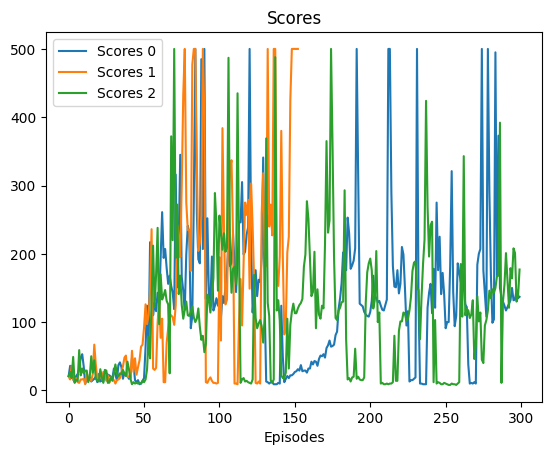

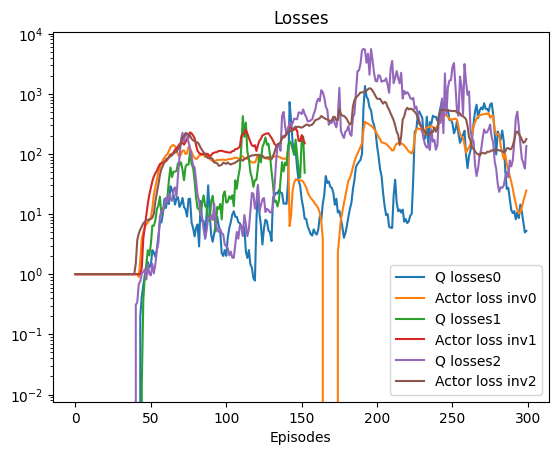

In [38]:
# Plot the scores and losses vs the episodes
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.plot(episodes[i], scores[i], label='Scores ' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Scores')
plt.show()

# Plot the losses
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.semilogy(episodes[i], [l[0] for l in losses[i]], label='Q losses' + str(i))
    ax1.plot(episodes[i], [-l[1] for l in losses[i]], label='Actor loss inv' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Losses')
plt.show()

Finally, we will visualize the learned policy. As in DQN, we must exploit, so we reduce the agent noise to a minimum in order not to explore.

Obtaining data from trained network
Data obtained
Creating animation


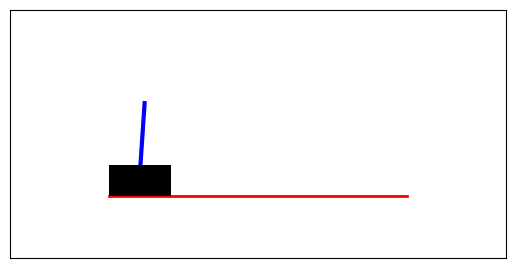

In [40]:
# Run the game once with the trained network and store the values of the position and angle of the cartpole
print("Obtaining data from trained network")
pos_vector=[]
angle_vector=[]
state = env.reset()
state = np.reshape(state, [1, agent.state_size])
agent.noise_std = 0.01
done=False
while not done:
    pos_vector.append(state[0,0])
    angle_vector.append(state[0,2])
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = np.reshape(next_state, [1, agent.state_size])
    state = next_state
    if done:
        break
T=len(pos_vector)
print("Data obtained")

# Animate the data: to observe what our network has learned
from matplotlib import animation, patches
from IPython.display import HTML
print("Creating animation")
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 3), aspect=1)
ax.set_xticks([])
ax.set_yticks([])

mag1 = plt.Rectangle((0,0), width= 1, height= 0.5, angle=0, fc='black', alpha=0)
line1, = ax.plot([], [], 'b', zorder=1,linewidth=3.0)
line2, = ax.plot([], [], 'r', zorder=1,linewidth=2.0)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax.add_patch(mag1)
    return mag1, line1, line2,

def animate(i):
    mag1.set_alpha(1)
    mag1.xy = (pos_vector[i],0)
    x0=pos_vector[i]+0.5
    y0=0.5
    x1=x0+np.cos(np.pi/2-angle_vector[i])
    y1=y0+np.sin(np.pi/2-angle_vector[i])
    line1.set_data([x0, x1], [y0, y1])
    line2.set_data([-2.4, 2.4], [0,0])
    return mag1, line1, line2,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T,
                               interval=25, blit=True)

HTML(anim.to_jshtml())